<a href="https://colab.research.google.com/github/rickic45/Data_Mining_Titanic/blob/main/data_mining_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Understanding & Preparation


In [29]:
# Import all necessary libraries for our analysis. We will use:

import numpy as np              # For mathematical operations and array manipulation
import pandas as pd             # For handling and analyzing tabular data
import matplotlib.pyplot as plt # For creating plots
import seaborn as sns           # For advanced statistical visualizations

# Specific machine learning libraries from scikit-learn
from sklearn import datasets                                    # To load datasets
from sklearn.model_selection import train_test_split            # To split data into training and test sets
from sklearn.model_selection import GridSearchCV, cross_val_score # For hyperparameter tuning and validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # For data normalization
from sklearn.decomposition import PCA                           # For dimensionality reduction
from sklearn.pipeline import Pipeline                           # To create preprocessing+model pipelines

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Classification models
from sklearn.linear_model import LogisticRegression    # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier     # K-Nearest Neighbors
from sklearn.svm import SVC                            # Support Vector Machine
from sklearn.tree import DecisionTreeClassifier        # Decision Tree
from sklearn.ensemble import (                         # Ensemble methods
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier      # Multi-layer Perceptron (neural networks)

# To save models
import joblib

# To ignore warnings (optional)
import warnings
warnings.filterwarnings('ignore')


In [30]:
# Load Titanic
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("titanic.csv")

# Create new features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['HasCabin'] = df['Cabin'].notnull().astype(int)

# Extract Title from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace(['Mme', 'Lady', 'Countess', 'Dona'], 'Mrs')
df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev', 'Jonkheer', 'Don', 'Sir'], 'Rare')

# Drop unused columns
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)


Saving titanic.csv to titanic (1).csv


In [31]:
# Missing values
print("Missing values:")
print(df.isnull().sum())

# Duplicates
print("Duplicates:", df.duplicated().sum())

# Columns with same value
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Constant columns:", constant_cols)


Missing values:
PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
FamilySize       0
IsAlone          0
HasCabin         0
Title            0
dtype: int64
Duplicates: 0
Constant columns: []


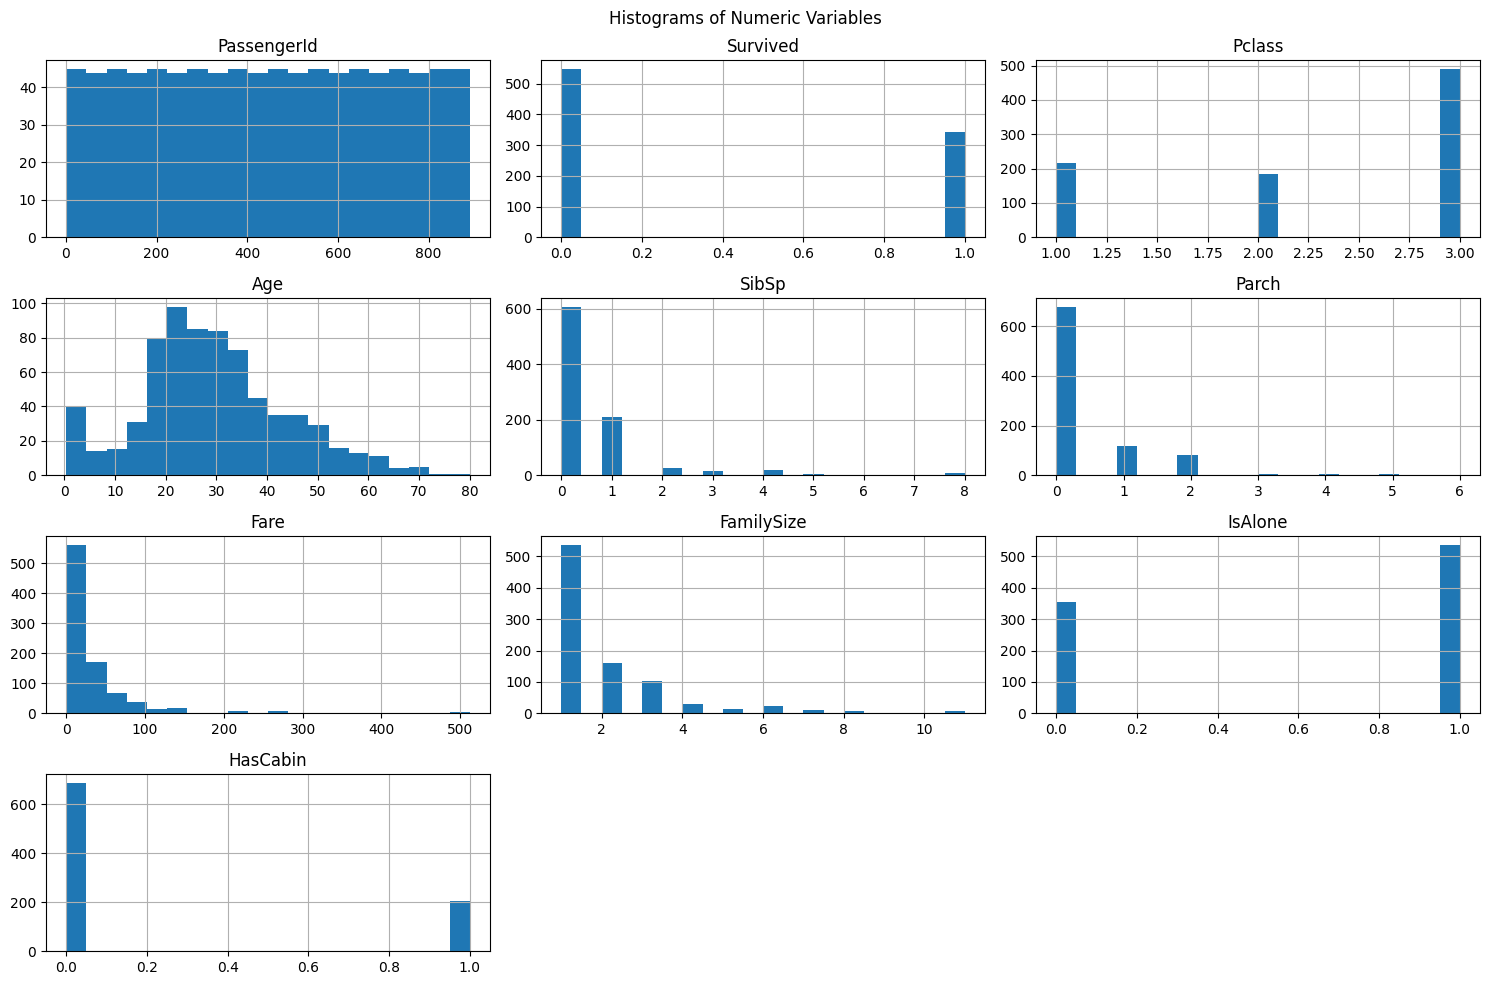

In [32]:

# Numeric distributions
df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Variables")
plt.tight_layout()
plt.show()


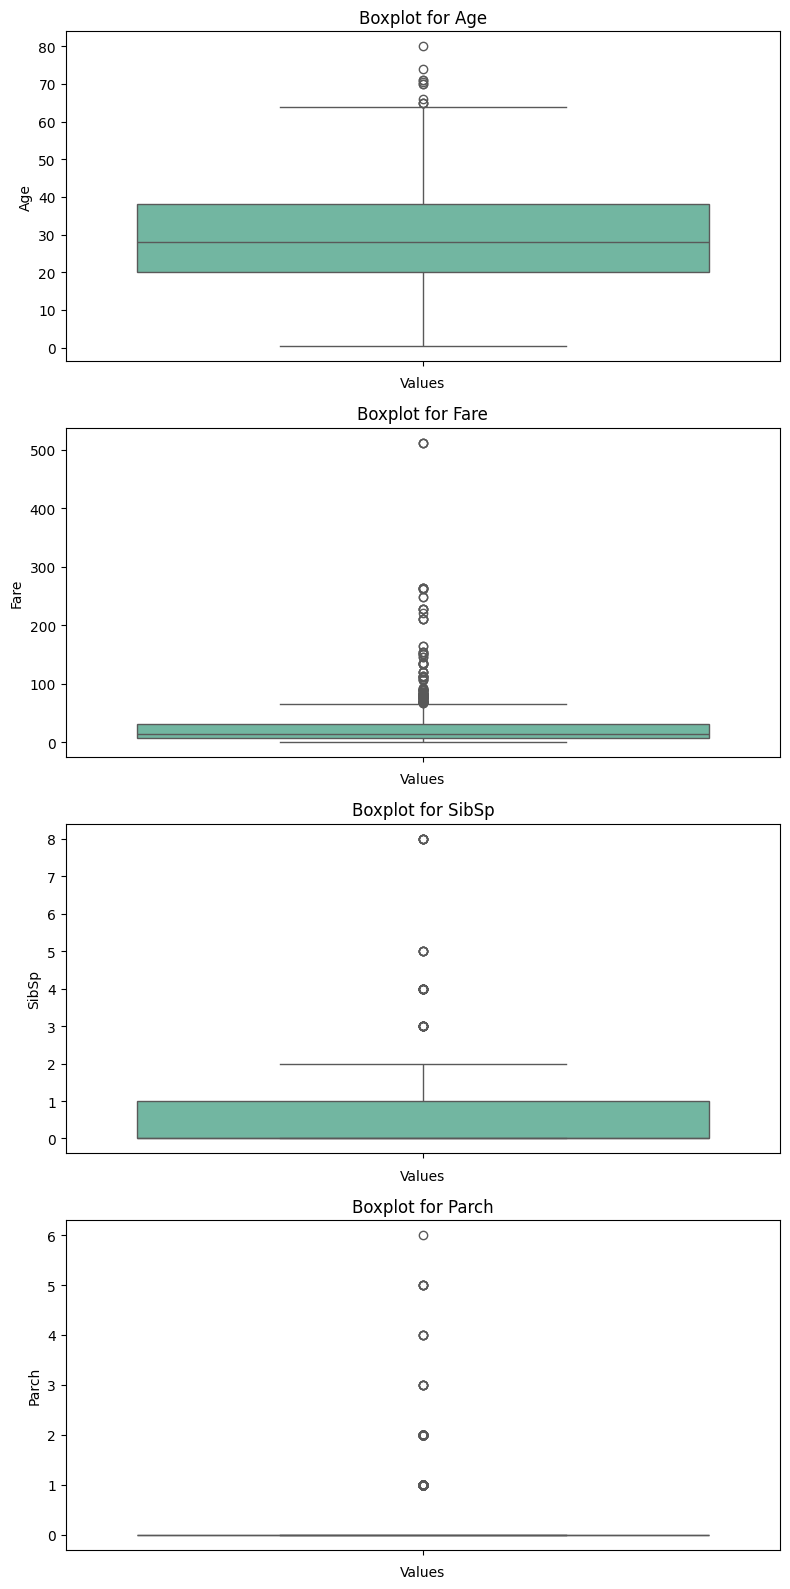

In [33]:

# List of numerical columns to plot
numerical_columns = ['Age', 'Fare', 'SibSp', 'Parch']

# Set up the figure size and layout for 4 subplots (vertically arranged)
fig, axes = plt.subplots(4, 1, figsize=(8, 16))

# Create a boxplot for each of the numerical columns
sns.boxplot(data=df, y='Age', palette='Set2', ax=axes[0])
axes[0].set_title('Boxplot for Age')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Age')

sns.boxplot(data=df, y='Fare', palette='Set2', ax=axes[1])
axes[1].set_title('Boxplot for Fare')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Fare')

sns.boxplot(data=df, y='SibSp', palette='Set2', ax=axes[2])
axes[2].set_title('Boxplot for SibSp')
axes[2].set_xlabel('Values')
axes[2].set_ylabel('SibSp')

sns.boxplot(data=df, y='Parch', palette='Set2', ax=axes[3])
axes[3].set_title('Boxplot for Parch')
axes[3].set_xlabel('Values')
axes[3].set_ylabel('Parch')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Columns with correlation higher than 0.9: []
No columns were removed. The dataset may already be sparse.


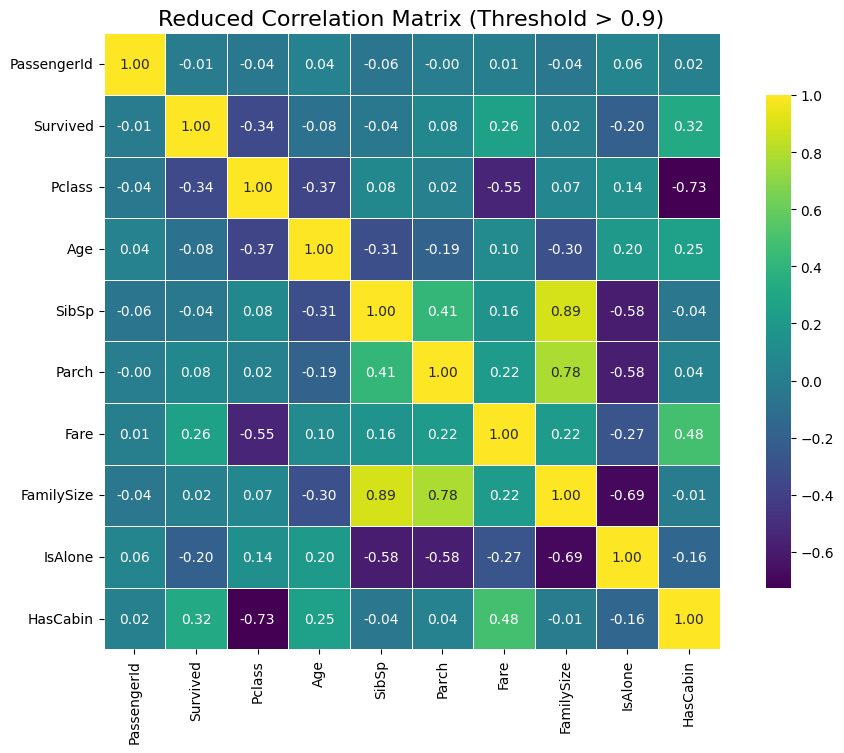

In [34]:

# Set the correlation threshold (e.g., 0.9)
threshold = 0.9

# Create a correlation matrix
corr = df.corr(numeric_only=True)

# Find the columns with high correlation
high_corr_columns = [column for column in corr.columns if any(abs(corr[column]) > threshold) and column not in corr.columns]

# Check how many columns were dropped
print(f"Columns with correlation higher than {threshold}: {high_corr_columns}")

# If no columns were dropped, continue with the original df
if high_corr_columns:
    df_reduced = df.drop(columns=high_corr_columns)
else:
    print("No columns were removed. The dataset may already be sparse.")
    df_reduced = df

# Plot the correlation matrix for the reduced dataframe (only if the reduced dataframe is not empty)
if not df_reduced.empty:
    # Create the correlation matrix for the reduced dataframe
    corr_reduced = df_reduced.corr(numeric_only=True)

    # Set figure size for better readability
    plt.figure(figsize=(12, 8))

    # Use a different color map and adjust the font size of annotations
    sns.heatmap(corr_reduced, annot=True, fmt=".2f", cmap='viridis', annot_kws={'size': 10},
                cbar_kws={'shrink': 0.8}, linewidths=0.5, square=True)

    # Title and display
    plt.title(f"Reduced Correlation Matrix (Threshold > {threshold})", fontsize=16)
    plt.show()
else:
    print("No data to plot. The dataframe is empty after applying the threshold.")


In [35]:
df.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2
FamilySize,0


In [36]:
df_encoded = pd.get_dummies(df, drop_first=True)


In [37]:
df['log_Fare'] = np.log1p(df['Fare'])  # example on Fare


In [38]:
df.to_csv("titanic_cleaned.csv", index=False)


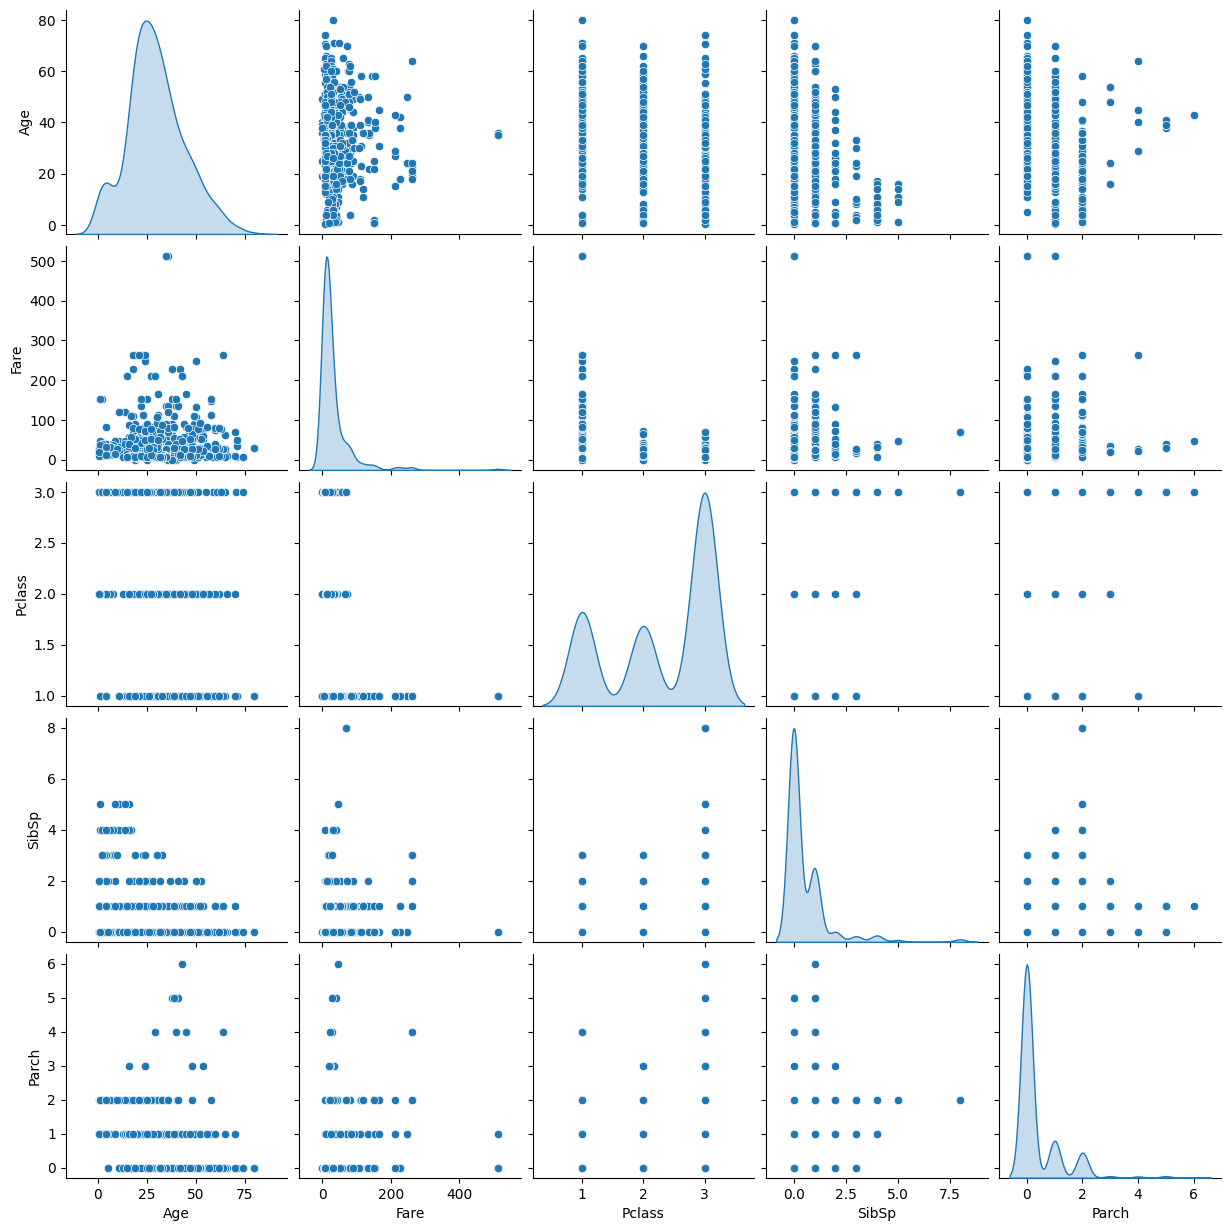

In [39]:
sns.pairplot(df[['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']], diag_kind='kde')


In [40]:
df_corr = df.copy()
df_corr['Survived'] = pd.read_csv("titanic.csv")['Survived']  # if missing
corr_target = df_corr.corr(numeric_only=True)['Survived'].sort_values(ascending=False)
print(corr_target)


Survived       1.000000
log_Fare       0.329862
HasCabin       0.316912
Fare           0.257307
Parch          0.081629
FamilySize     0.016639
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
IsAlone       -0.203367
Pclass        -0.338481
Name: Survived, dtype: float64


Clustering

In [41]:

# Load the cleaned dataset
df = pd.read_csv("titanic.csv")

# Drop rows with nulls in relevant columns
df_clust = df[['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']].dropna()

# Normalize features (important for distance-based clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clust)


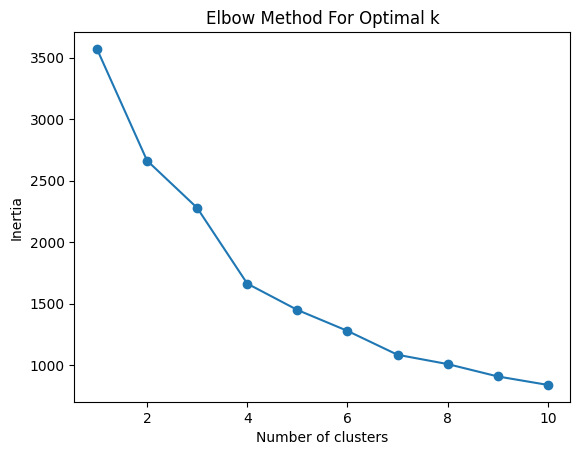

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_clust['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# View cluster means
print(df_clust.groupby('kmeans_cluster').mean())


                      Age        Fare    Pclass     SibSp     Parch
kmeans_cluster                                                     
0               31.960000  153.435737  1.461538  0.711538  2.153846
1               23.377815   15.101651  2.761261  0.569820  0.382883
2               42.034404   46.275650  1.353211  0.348624  0.119266


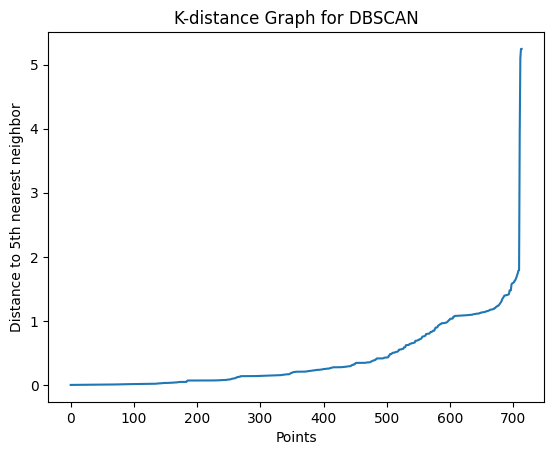

In [44]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


# Use NearestNeighbors to guess epsilon
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# Sort and plot distances
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.title("K-distance Graph for DBSCAN")
plt.xlabel("Points")
plt.ylabel("Distance to 5th nearest neighbor")
plt.show()


In [45]:
db = DBSCAN(eps=0.5, min_samples=5)
df_clust['dbscan_cluster'] = db.fit_predict(X_scaled)

# Count cluster labels
print(df_clust['dbscan_cluster'].value_counts())


dbscan_cluster
 2     220
-1     180
 5      90
 3      70
 1      39
 0      30
 7      25
 4      12
 9      10
 12      9
 8       8
 6       8
 10      8
 11      5
Name: count, dtype: int64


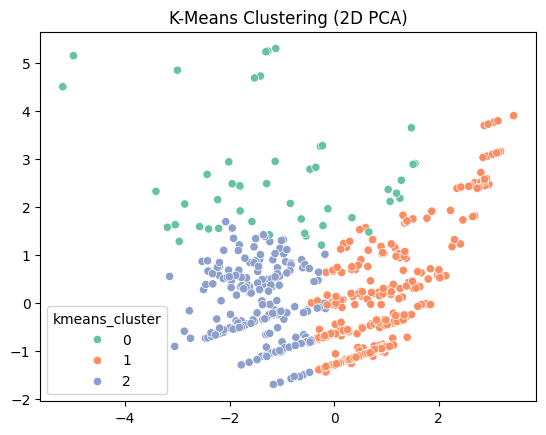

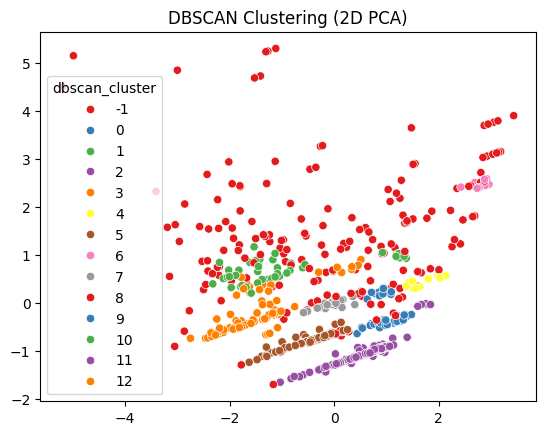

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means plot
plt.figure()
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clust['kmeans_cluster'], palette='Set2')
plt.title("K-Means Clustering (2D PCA)")
plt.show()

# DBSCAN plot
plt.figure()
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clust['dbscan_cluster'], palette='Set1')
plt.title("DBSCAN Clustering (2D PCA)")
plt.show()


Text(0.5, 1.0, 'K-Means Cluster Distribution')

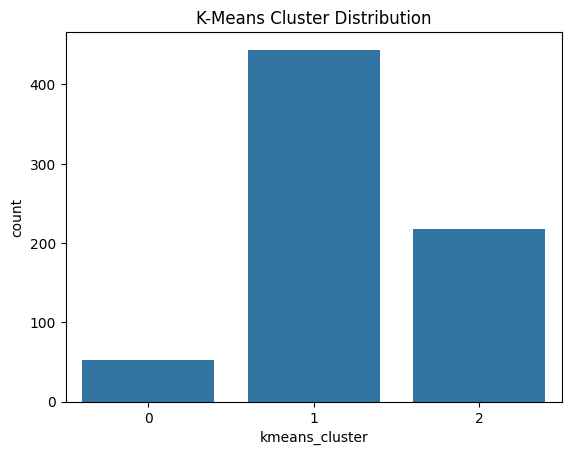

In [47]:
sns.countplot(x='kmeans_cluster', data=df_clust)
plt.title("K-Means Cluster Distribution")


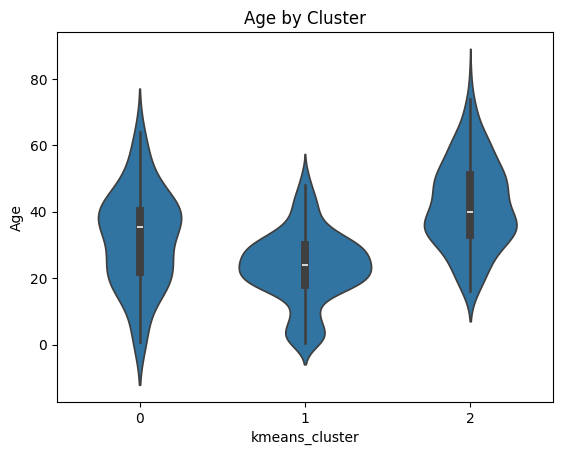

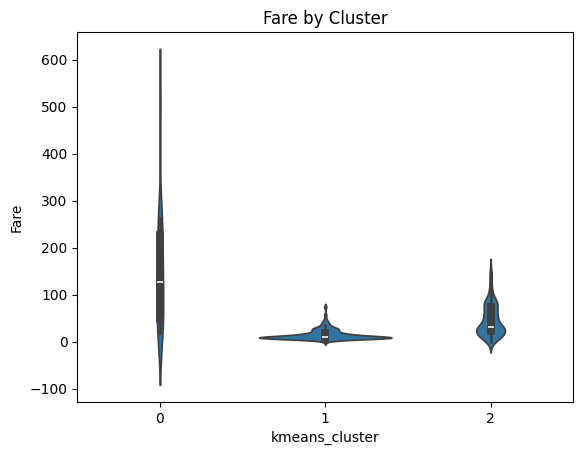

In [48]:
for col in ['Age', 'Fare']:
    sns.violinplot(x='kmeans_cluster', y=col, data=df_clust)
    plt.title(f"{col} by Cluster")
    plt.show()


Classification

In [49]:
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("titanic.csv")

# Drop rows with missing values in key columns
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].dropna()

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Split X and y
X = df.drop('Survived', axis=1)
y = df['Survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
print("Decision Tree:\n", classification_report(y_test, y_pred_tree))


Decision Tree:
               precision    recall  f1-score   support

           0       0.73      0.78      0.75        80
           1       0.69      0.63      0.66        63

    accuracy                           0.71       143
   macro avg       0.71      0.70      0.71       143
weighted avg       0.71      0.71      0.71       143



In [51]:
# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
print("KNN:\n", classification_report(y_test, y_pred_knn))


KNN:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72        80
           1       0.65      0.67      0.66        63

    accuracy                           0.69       143
   macro avg       0.69      0.69      0.69       143
weighted avg       0.69      0.69      0.69       143



In [52]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))


Naive Bayes:
               precision    recall  f1-score   support

           0       0.78      0.81      0.80        80
           1       0.75      0.71      0.73        63

    accuracy                           0.77       143
   macro avg       0.77      0.76      0.76       143
weighted avg       0.77      0.77      0.77       143



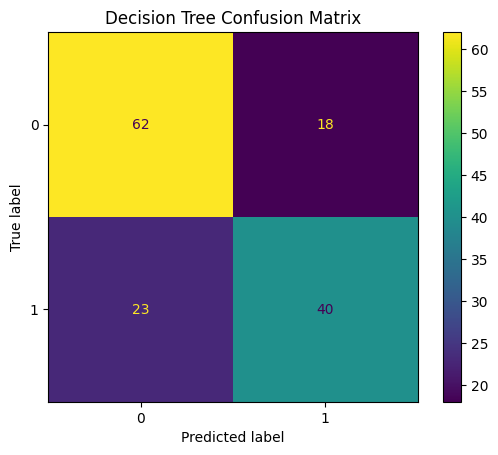

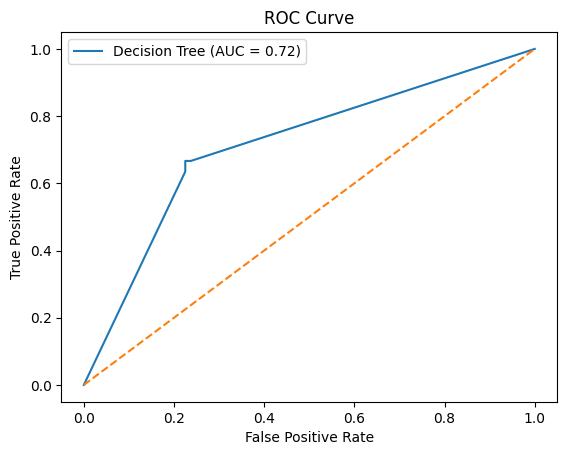

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


# Example for Decision Tree
cm = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

# ROC Curve
y_proba_tree = tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


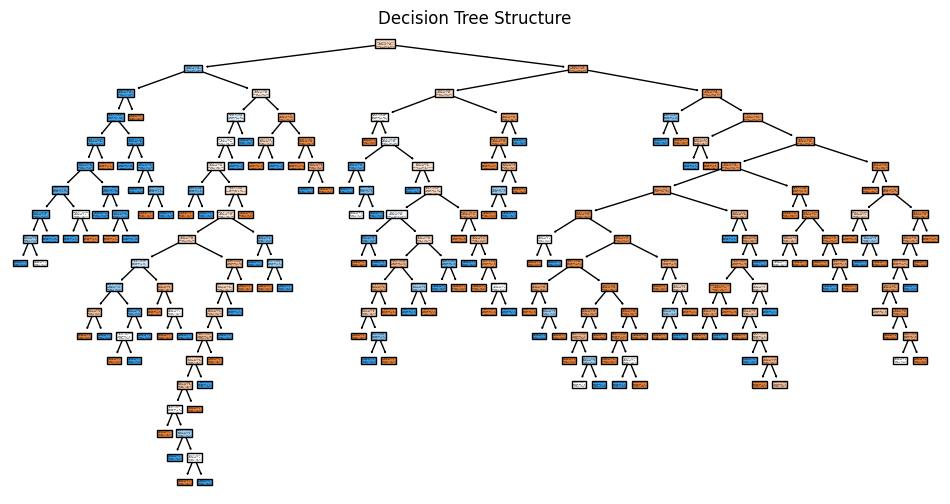

In [54]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,6))
plot_tree(tree, feature_names=X.columns, class_names=["No", "Yes"], filled=True)
plt.title("Decision Tree Structure")
plt.show()


Pattern Mining

In [55]:

# Load dataset
df = pd.read_csv("titanic.csv")

# Keep only relevant + categorical features
df = df[['Survived', 'Pclass', 'Sex', 'Embarked']].dropna()

# Convert to string type for transaction encoding
df = df.astype(str)

# One-hot encode
df_encoded = pd.get_dummies(df)


In [56]:
from mlxtend.frequent_patterns import apriori

# Find frequent itemsets with min support
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

# Sort by length of itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print(frequent_itemsets.sort_values(by=['support', 'length'], ascending=False))


     support                                      itemsets  length
8   0.724409                                  (Embarked_S)       1
6   0.649044                                    (Sex_male)       1
0   0.617548                                  (Survived_0)       1
4   0.552306                                    (Pclass_3)       1
11  0.526434                        (Sex_male, Survived_0)       2
29  0.496063                        (Sex_male, Embarked_S)       2
12  0.480315                      (Survived_0, Embarked_S)       2
10  0.418448                        (Pclass_3, Survived_0)       2
33  0.409449            (Sex_male, Survived_0, Embarked_S)       3
26  0.397075                        (Pclass_3, Embarked_S)       2
25  0.390326                          (Sex_male, Pclass_3)       2
1   0.382452                                  (Survived_1)       1
5   0.350956                                  (Sex_female)       1
31  0.337458              (Sex_male, Pclass_3, Survived_0)    

In [57]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)

# Sort by confidence and lift
rules_sorted = rules.sort_values(by=['lift', 'confidence'], ascending=False)
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


                           antecedents               consequents   support  \
31              (Sex_female, Pclass_1)              (Survived_1)  0.100112   
7                         (Sex_female)              (Survived_1)  0.259843   
8                         (Survived_1)              (Sex_female)  0.259843   
32              (Survived_1, Pclass_1)              (Sex_female)  0.100112   
35            (Survived_1, Embarked_S)              (Sex_female)  0.157480   
34            (Sex_female, Embarked_S)              (Survived_1)  0.157480   
6                           (Pclass_1)              (Survived_1)  0.150731   
18              (Survived_0, Pclass_2)                (Sex_male)  0.102362   
41    (Sex_male, Pclass_3, Embarked_S)              (Survived_0)  0.259843   
19                (Sex_male, Pclass_3)              (Survived_0)  0.337458   
44                (Sex_male, Pclass_3)  (Survived_0, Embarked_S)  0.259843   
17                (Sex_male, Pclass_2)              (Survived_0)

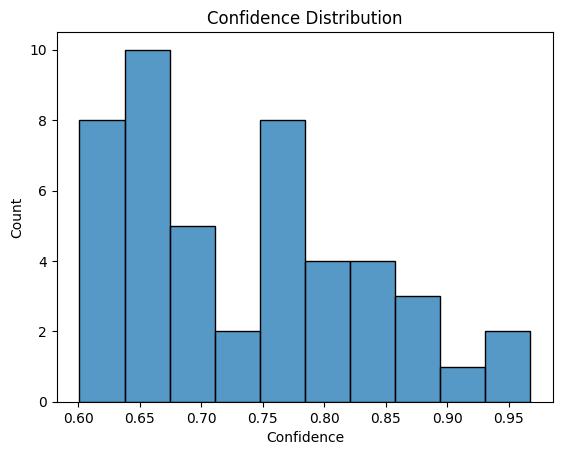

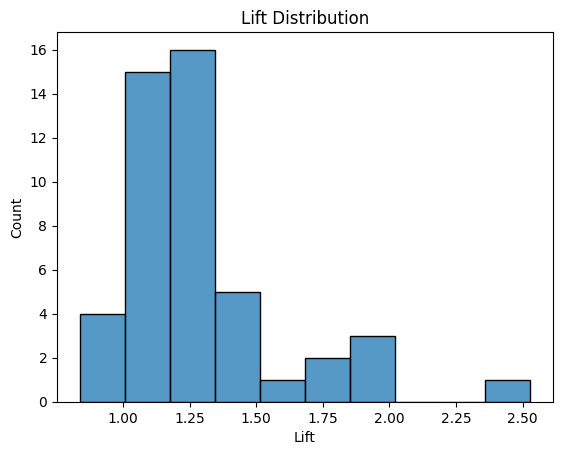

In [58]:


# Histogram of confidence
plt.figure()
sns.histplot(rules['confidence'], bins=10, kde=False)
plt.title("Confidence Distribution")
plt.xlabel("Confidence")
plt.show()

# Histogram of lift
plt.figure()
sns.histplot(rules['lift'], bins=10, kde=False)
plt.title("Lift Distribution")
plt.xlabel("Lift")
plt.show()

In [59]:

df = pd.read_csv("titanic.csv")

# Keep and drop missing
df = df[['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Sex', 'Embarked']].dropna()

# One-hot encode
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Split
X = df.drop('Fare', axis=1)
y = df['Fare']


Text(0.5, 1.0, 'Rules: Confidence vs Lift')

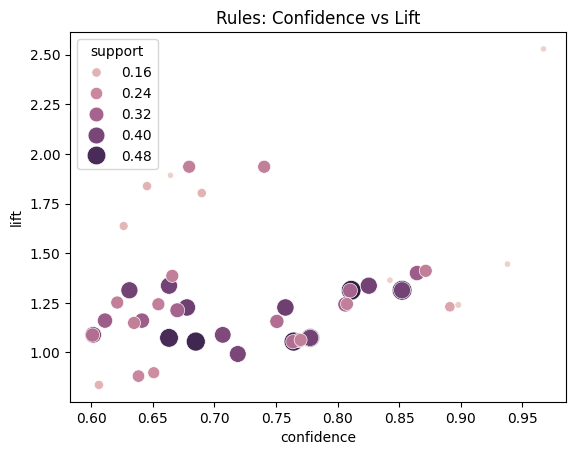

In [60]:
sns.scatterplot(data=rules, x='confidence', y='lift', size='support', hue='support', sizes=(20,200))
plt.title("Rules: Confidence vs Lift")


In [61]:
top_rules = rules.sort_values('lift', ascending=False).head(10)
for _, row in top_rules.iterrows():
    print(f"{set(row['antecedents'])} => {set(row['consequents'])} | Lift={row['lift']:.2f}")


{'Sex_female', 'Pclass_1'} => {'Survived_1'} | Lift=2.53
{'Survived_1'} => {'Sex_female'} | Lift=1.94
{'Sex_female'} => {'Survived_1'} | Lift=1.94
{'Survived_1', 'Pclass_1'} => {'Sex_female'} | Lift=1.89
{'Survived_1', 'Embarked_S'} => {'Sex_female'} | Lift=1.84
{'Sex_female', 'Embarked_S'} => {'Survived_1'} | Lift=1.80
{'Pclass_1'} => {'Survived_1'} | Lift=1.64
{'Survived_0', 'Pclass_2'} => {'Sex_male'} | Lift=1.45
{'Sex_male', 'Pclass_3', 'Embarked_S'} => {'Survived_0'} | Lift=1.41
{'Sex_male', 'Pclass_3'} => {'Survived_0'} | Lift=1.40


In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Evaluate
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Coefficients:", list(zip(X.columns, reg.coef_)))


R²: 0.30199102009025736
MSE: 3612.489935615515
Coefficients: [('Pclass', np.float64(-30.842076967496414)), ('Age', np.float64(-0.08455054638995418)), ('SibSp', np.float64(7.139263594494712)), ('Parch', np.float64(9.119424752599866)), ('Sex_male', np.float64(-7.431933493564966)), ('Embarked_Q', np.float64(-9.676847462812177)), ('Embarked_S', np.float64(-13.652011025898418))]


In [63]:
from sklearn.linear_model import Ridge, Lasso

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
print("Ridge R²:", ridge.score(X_test, y_test))

# Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print("Lasso R²:", lasso.score(X_test, y_test))


Ridge R²: 0.30116742543123265
Lasso R²: 0.29893366744954997


In [64]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_tree_pred = tree.predict(X_test)

print("Tree R²:", r2_score(y_test, y_tree_pred))


Tree R²: 0.3306790708156627


Text(0.5, 1.0, 'Prediction vs Actual')

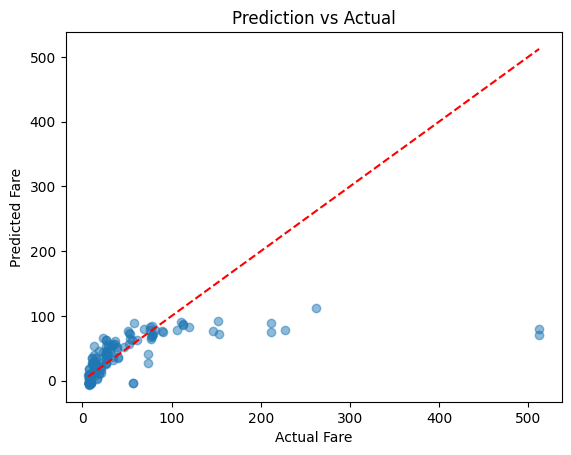

In [65]:

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Prediction vs Actual")


Text(0.5, 1.0, 'Residuals Histogram')

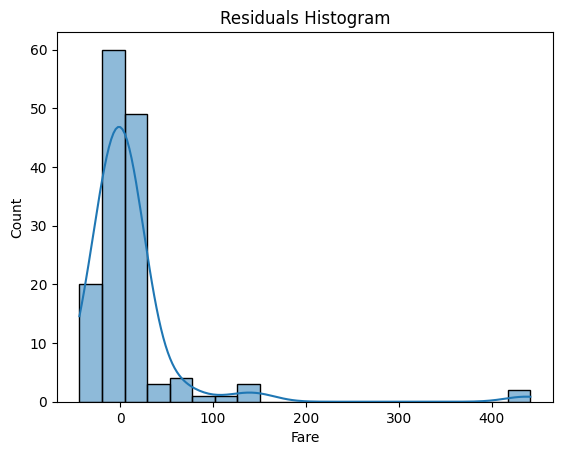

In [66]:
residuals = y_test - y_pred
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residuals Histogram")
